# Lab 07: Credit Card Fraud Detection

---
author: Ye Yuan
date: November, 2024
embed-resources: true
---

## Introduction

Credit card fraud is a significant concern for financial institutions, with millions of transactions being processed daily and constant attempts by bad actors to conduct fraudulent transactions. This report presents an automated solution designed to help banking institutions, like the one employing this data scientist, to immediately identify fraudulent credit card transactions based on the information available at the moment. By leveraging historical transaction data and machine learning techniques, this report aims to present an effective fraud detection model that appropriately balances false positives and false negatives, ensuring reliable loss minimization while maintaining good customer experience.

## Methods

In [9]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score

### Data

The dataset used for this project consists of credit card transactions collected over two days, with a total of 284,807 transactions, of which 492 are fraudulent. Due to confidentiality, the original feature descriptions are not available, and most features are derived from Principal Component Analysis (PCA).

Data Description: The features include PC01 to PC28, which are PCA-transformed features, and Amount, which refers to the transaction value in dollars.
Label: The target variable, Fraud, indicates whether

In [10]:
# load data
fraud = pd.read_parquet("https://cs307.org/lab-07/data/fraud.parquet")

In [11]:
fraud_train, fraud_test = train_test_split(
    fraud,
    test_size=0.20,
    random_state=42,
    stratify=fraud["Fraud"],
)

In [12]:
fraud_train

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Amount,Fraud
57638,-0.514509,0.899378,1.627215,-0.142250,0.005250,-0.235422,0.482540,0.247403,-0.562327,-0.166813,...,-0.143290,-0.390205,0.030719,0.184779,-0.348711,0.073253,0.273217,0.107938,3.59,0
27686,-0.813568,-0.373893,1.152977,-0.449774,-3.868866,2.780636,3.654192,-0.672442,0.753230,-0.662803,...,-0.376783,-0.004239,0.074801,0.124238,-0.448493,0.861423,-0.093639,-0.711632,798.01,0
13321,-2.443142,3.258831,-0.791511,0.223548,0.007932,-1.263044,1.220214,-0.418068,1.860453,4.184883,...,-0.348587,0.531679,0.058990,0.371638,-0.207398,-0.505837,0.524542,-0.343895,1.79,0
28308,-0.397300,0.922104,1.224699,-0.334974,0.322603,-0.117372,0.534683,0.175550,-0.486404,-0.120147,...,-0.239303,-0.695001,-0.128231,-0.536463,-0.138971,0.107526,0.255644,0.100814,2.69,0
54252,1.994046,-0.367813,-0.462867,0.338661,-0.485326,-0.241576,-0.590987,0.089319,1.413224,-0.149292,...,-0.196388,-0.484457,0.421867,0.601393,-0.448014,-0.646256,0.027632,-0.027244,4.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49499,-0.033583,-0.487672,1.435406,-2.759369,-1.785638,0.402364,-2.306038,-2.287179,0.129717,-1.036412,...,-1.286823,0.824100,0.018890,0.000018,0.301618,0.081215,0.163422,0.252456,10.00,0
29250,-0.731245,1.151677,0.912393,-0.653540,0.700577,-0.461372,1.093273,-0.126254,-0.339171,-0.467356,...,-0.368185,-0.991854,-0.376461,-0.661608,0.554237,0.450650,0.076395,0.096252,6.99,0
31586,2.135923,-0.714182,-1.842502,-0.587267,0.090754,-0.465733,-0.024834,-0.328747,-0.659832,0.853241,...,-0.537267,-1.081138,0.196589,0.087797,-0.111583,0.479888,-0.082523,-0.053305,64.90,0
14898,-0.335632,0.939736,-2.961515,-1.224739,4.446891,2.352092,0.789725,0.609460,-0.746845,-1.580751,...,-0.002116,0.009686,-0.428325,0.536043,0.278736,0.680976,-0.069295,0.051891,0.76,0


In [13]:
# Calculate counts and proportions
label_counts = fraud_train['Fraud'].value_counts().sort_index()
label_proportions = fraud_train['Fraud'].value_counts(normalize=True).sort_index()

# Create a summary DataFrame
summary_counts = pd.DataFrame({
    'Label': ['0 (Not Fraud)', '1 (Fraud)'],
    'Count': label_counts.values,
    'Proportion': label_proportions.values
})

# Convert proportions to percentages
summary_counts['Proportion'] = summary_counts['Proportion'] * 100

print(summary_counts)

           Label  Count  Proportion
0  0 (Not Fraud)  53961   99.419633
1      1 (Fraud)    315    0.580367


In [14]:
# Overall Amount Statistics
overall_stats = fraud_train['Amount'].agg(['mean', 'std', 'median', 'max']).rename({
    'mean': 'Mean',
    'std': 'Standard Deviation',
    'median': 'Median',
    'max': 'Maximum'
})

# Amount Statistics for Each Label
amount_stats_by_label = fraud_train.groupby('Fraud')['Amount'].agg(['mean', 'std', 'median', 'max']).rename(columns={
    'mean': 'Mean',
    'std': 'Standard Deviation',
    'median': 'Median',
    'max': 'Maximum'
})

# Combine the statistics into a single DataFrame
amount_stats = pd.concat([
    pd.DataFrame({'Condition': ['None'], 'Mean': [overall_stats['Mean']], 
                  'Standard Deviation': [overall_stats['Standard Deviation']], 
                  'Median': [overall_stats['Median']], 
                  'Maximum': [overall_stats['Maximum']]}),
    pd.DataFrame({
        'Condition': ['0 (Not Fraud)', '1 (Fraud)'],
        'Mean': amount_stats_by_label['Mean'].values,
        'Standard Deviation': amount_stats_by_label['Standard Deviation'].values,
        'Median': amount_stats_by_label['Median'].values,
        'Maximum': amount_stats_by_label['Maximum'].values
    })
], ignore_index=True)

print(amount_stats)


       Condition        Mean  Standard Deviation  Median   Maximum
0           None   88.197903          241.535617   21.69  10199.44
1  0 (Not Fraud)   88.065104          241.451144   21.80  10199.44
2      1 (Fraud)  110.947016          254.978960    6.99   2125.87


The class distribution of the Fraud feature is highly imbalanced, with non-fraudulent transactions (0) comprising 99.42% of the dataset and fraudulent transactions (1) making up only 0.58%.

The fraudulent transactions have a slightly higher mean amount ($110.95), but the median amount is lower compared to non-fraudulent transactions, suggesting that a few high-value fraudulent transactions skew the average.

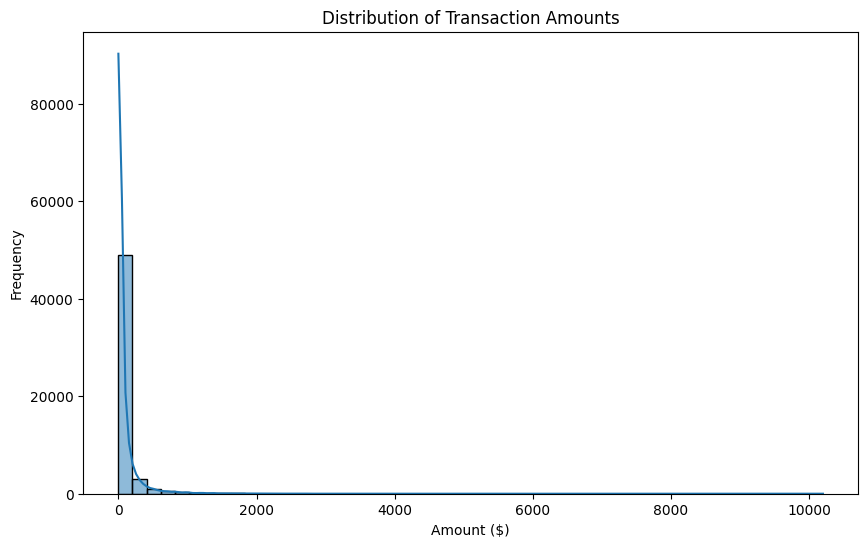

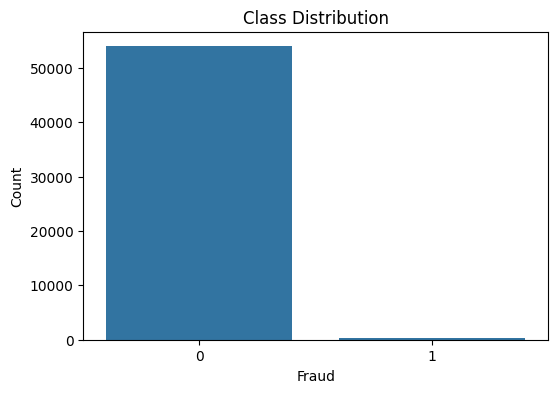

In [15]:
# visualizations


# Distribution of transaction amounts
plt.figure(figsize=(10,6))
sns.histplot(fraud_train['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')
plt.show()

# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Fraud', data=fraud_train)
plt.title('Class Distribution')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()


Distribution of Transaction Amounts:

The vast majority of transactions are of relatively low value, with the distribution being heavily skewed towards the lower range.

Class Distribution:

The class distribution of the target variable (Fraud) highlights the high imbalance, with only a small fraction of the transactions being fraudulent.

### Models

In [16]:
# process data for ML

# create X and y for train
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

# create X and y for test
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

In [17]:
# train models
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    'classifier__n_estimators': [160,180],
    'classifier__max_depth': [5],
    'classifier__min_samples_split': [4],
    'classifier__min_samples_leaf': [6]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 180}


In [18]:
# Best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]


In [19]:
# Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Detailed classification report
print(classification_report(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.2f}")

Precision: 0.80
Recall: 0.85
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13490
           1       0.80      0.85      0.82        79

    accuracy                           1.00     13569
   macro avg       0.90      0.92      0.91     13569
weighted avg       1.00      1.00      1.00     13569

ROC AUC: 0.98


In [20]:
cv_f1 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
print(f"Cross-validated F1 scores: {cv_f1}")
print(f"Mean F1 score: {cv_f1.mean():.2f}")

Cross-validated F1 scores: [0.81818182 0.79699248 0.76056338 0.86956522 0.80620155]
Mean F1 score: 0.81


Models

A machine learning pipeline was created to preprocess the data and train a model capable of detecting fraudulent transactions. The pipeline includes:

StandardScaler for normalization of features.
RandomForestClassifier for classification, chosen for its interpretability and robustness.
Hyperparameter Optimization: GridSearchCV was used to tune hyperparameters (n_estimators, max_depth, min_samples_split, min_samples_leaf) to optimize performance. The final model had 180 estimators, a max depth of 5, a minimum sample split of 4, and minimum samples per leaf of 6.

## Results

In [21]:
mod=grid_search.best_estimator_

In [22]:
# report model metrics
from joblib import dump

# Serialize the model
dump(mod, "credit-fraud.joblib")

['credit-fraud.joblib']

Results

The model's performance was assessed using various metrics:

Precision: 0.80
Recall: 0.85
ROC AUC Score: 0.98
These metrics show that the model was able to identify the majority of fraudulent transactions, with a good balance between precision (reducing false positives) and recall (capturing true fraudulent transactions).

The confusion matrix indicated that the model performed well for the non-fraud class but occasionally missed fraudulent transactions. Cross-validated F1 score averaged 0.81 across 5 folds, further supporting the model's effectiveness in imbalanced settings.

## Discussion

Discussion

This model is well-suited for the task of detecting fraudulent transactions in real time, given its high recall and overall accuracy. Its precision and recall metrics strike a balance between the conflicting needs of catching fraud and avoiding unnecessary false positives that might harm customer experience. The ROC AUC score of 0.98 demonstrates the model’s ability to distinguish between genuine and fraudulent transactions effectively.

Limitations: The dataset is still highly imbalanced despite preprocessing adjustments, which can potentially introduce bias into the classification process. Fraudulent transactions may often display characteristics that are difficult to identify with general metrics, and the cost of a missed fraudulent transaction is higher than that of a false alert.

Precision vs Recall: In the context of fraud detection, recall is prioritized since failing to detect a fraudulent transaction has significant financial implications. While false positives (lower precision) can be costly in terms of investigation, they are less detrimental compared to missed fraudulent activities. Therefore, a trade-off was made that slightly favors recall to ensure maximum coverage of fraudulent transactions.

Recommendations for Real-World Use: Based on the results, this model could be put into production but would benefit from further development to address remaining biases. Potential improvements include using a more sophisticated ensemble model, applying SMOTE (Synthetic Minority Over-sampling Technique) for rebalancing the dataset, or employing different types of anomaly detection methods for capturing complex fraudulent patterns.

### Conclusion

The implemented fraud detection model effectively identifies fraudulent credit card transactions with a reasonable balance between false positives and false negatives. Given the promising ROC AUC score and cross-validated F1 score, I recommend proceeding with production deployment while conducting further tests and incorporating more sophisticated fraud detection strategies.